In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PER_EPOCH_FNAME = "./outputs/per_epoch_for_d3.csv"
per_epoch_df = pd.read_csv(PER_EPOCH_FNAME, header=0, index_col=False).query("k != 1")
METRIC_COLNAMES = [
    "average_local_error",
    "class_aware_continuity",
    "class_aware_trustworthiness",
    "continuity",
    "distance_consistency",
    "false_neighbors",
    "jaccard",
    "mrre_data",
    "mrre_proj",
    "neighborhood_hit",
    "normalized_stress",
    "pearson_correlation",
    "procrustes",
    "scale_normalized_stress",
    "shepard_goodness",
    "true_neighbors",
    "trustworthiness",
]
def _id(x):
    return x

def _flip(x):
    return 1 - x
def _negate(x):
    return -x

def _shift_scale(shift:float, scale: float):
    return lambda x: scale * (x - shift)

def _shift(by:float):
    return _shift_scale(by, 1.0)

def _flip_shift(by:float):
    return lambda x: by - x

adapters = {k: _id for k in per_epoch_df.columns}
adapters |=  {
    "average_local_error": _negate,
    "class_aware_continuity": _id,
    "class_aware_trustworthiness": _id,
    "continuity": _id,
    "distance_consistency": _id,
    "false_neighbors": _negate,
    "jaccard": _id,
    "mrre_data": _negate,
    "mrre_proj": _negate,
    "neighborhood_hit": _id,
    "normalized_stress": _negate,
    "pearson_correlation": _shift_scale(-1, 0.5),
    "procrustes": _negate,
    "scale_normalized_stress": _negate,
    "shepard_goodness": _shift_scale(-1, 0.5),
    "true_neighbors": _id,
    "trustworthiness": _id,

}
adapted_per_epoch_df = per_epoch_df.transform(adapters)

In [2]:
NICE_METRIC_NAMES = {
    "average_local_error": "Avg. Local Error",
    "class_aware_continuity": "Class-Aware Cont.",
    "class_aware_trustworthiness": "Class-Aware Trustw.",
    "continuity": "Continuity",
    "distance_consistency": "Dist. Consistency",
    "false_neighbors": "False Neighbors",
    "jaccard": "Jaccard",
    # "//" "missing_neighbors",
    "mrre_data": "MRRE Data",
    "mrre_proj": "MRRE Projection",
    "neighborhood_hit": "Neighborhood Hit",
    "normalized_stress": "Normalized Stress",
    "pearson_correlation": "Pearson R",
    "procrustes": "Procrustes",
    "scale_normalized_stress": "Scale-Norm. Stress",
    "shepard_goodness": "Shepard Goodness",
    "true_neighbors": "True Neighbors",
    "trustworthiness": "Trustworthiness",
    "all": "ALL",
}

In [19]:
after_fooling_df = adapted_per_epoch_df.query('epoch == 1000')

In [20]:
# Metric clusters from HDBSCAN:
# {-1: [(-1, 'distance_consistency'),
# (-1, 'neighborhood_hit'),
# (-1, 'normalized_stress'),
# (-1, 'procrustes')],
# 0: [(0, 'false_neighbors'), (0, 'jaccard'), (0, 'true_neighbors')],
# 1: [(1, 'average_local_error'),
# (1, 'pearson_correlation'),
# (1, 'scale_normalized_stress'),
# (1, 'shepard_goodness')],
# 2: [(2, 'class_aware_continuity'), (2, 'continuity'), (2, 'mrre_proj')],
# 3: [(3, 'class_aware_trustworthiness'),
# (3, 'mrre_data'),
# (3, 'trustworthiness')]}

CLUSTER_REPRESENTATIVES = [
    "continuity",
    "trustworthiness",
    "true_neighbors",
    "pearson_correlation",
    "distance_consistency",
    "neighborhood_hit",
    "procrustes",
    "normalized_stress",
]


In [21]:
after_fooling_df = after_fooling_df[['epoch', 'dataset', 'projection', 'metric', 'k'] + CLUSTER_REPRESENTATIVES].copy()

In [22]:
after_fooling_df.dropna(inplace=True)
after_fooling_df

,epoch,dataset,projection,metric,k,continuity,trustworthiness,true_neighbors,pearson_correlation,distance_consistency,neighborhood_hit,procrustes,normalized_stress
10,1000,har,umap,jaccard,7,0.974,0.981,0.240,0.8755,0.698,0.865,-0.994,-0.819
22,1000,spambase,mds,jaccard,51,0.600,0.612,0.094,0.4165,0.483,0.612,-0.900,-1.000
34,1000,usps,tsne,jaccard,51,0.921,0.953,0.374,0.6630,0.662,0.785,-0.955,-0.987
46,1000,spambase,tsne,jaccard,51,0.670,0.556,0.067,0.7060,0.641,0.616,-0.970,-0.555
58,1000,mnist,tsne,jaccard,51,0.902,0.937,0.348,0.6845,0.482,0.673,-0.957,-0.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,1000,reuters,tsne,all,7,0.712,0.592,0.026,0.4230,0.119,0.578,-0.892,-0.948
5662,1000,reuters,umap,all,7,0.655,0.634,0.048,0.4095,0.289,0.660,-0.862,-0.787
5674,1000,reuters,tsne,all,21,0.644,0.588,0.041,0.4040,0.164,0.586,-0.927,-0.885
5722,1000,usps,mds,all,21,0.945,0.961,0.285,0.8100,0.718,0.777,-1.000,-0.976


In [23]:
vals, bins = np.histogram(adapted_per_epoch_df[adapted_per_epoch_df.epoch==-1]['distance_consistency'], bins=20)
vals = vals / sum(1.0 * vals)

np.searchsorted(bins, 0.4)

3

In [24]:
vals

array([0.04166667, 0.        , 0.        , 0.        , 0.04166667,
       0.04166667, 0.08333333, 0.125     , 0.        , 0.125     ,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.08333333,
       0.125     , 0.08333333, 0.        , 0.        , 0.08333333])

In [25]:
import scipy.stats as st



transform_metrics = {
    m: lambda v: st.percentileofscore(adapted_per_epoch_df[adapted_per_epoch_df.epoch==-1][m].to_numpy(), v, kind='weak', nan_policy='omit')
    for m in CLUSTER_REPRESENTATIVES
}



In [26]:
after_fooling_df = after_fooling_df.drop(columns=['epoch'])
after_fooling_df

,dataset,projection,metric,k,continuity,trustworthiness,true_neighbors,pearson_correlation,distance_consistency,neighborhood_hit,procrustes,normalized_stress
10,har,umap,jaccard,7,0.974,0.981,0.240,0.8755,0.698,0.865,-0.994,-0.819
22,spambase,mds,jaccard,51,0.600,0.612,0.094,0.4165,0.483,0.612,-0.900,-1.000
34,usps,tsne,jaccard,51,0.921,0.953,0.374,0.6630,0.662,0.785,-0.955,-0.987
46,spambase,tsne,jaccard,51,0.670,0.556,0.067,0.7060,0.641,0.616,-0.970,-0.555
58,mnist,tsne,jaccard,51,0.902,0.937,0.348,0.6845,0.482,0.673,-0.957,-0.987
...,...,...,...,...,...,...,...,...,...,...,...,...
5650,reuters,tsne,all,7,0.712,0.592,0.026,0.4230,0.119,0.578,-0.892,-0.948
5662,reuters,umap,all,7,0.655,0.634,0.048,0.4095,0.289,0.660,-0.862,-0.787
5674,reuters,tsne,all,21,0.644,0.588,0.041,0.4040,0.164,0.586,-0.927,-0.885
5722,usps,mds,all,21,0.945,0.961,0.285,0.8100,0.718,0.777,-1.000,-0.976


In [27]:
CLUSTER_REPRESENTATIVES

['continuity',
 'trustworthiness',
 'true_neighbors',
 'pearson_correlation',
 'distance_consistency',
 'neighborhood_hit',
 'procrustes',
 'normalized_stress']

In [28]:
NICE_DATASET_NAMES  = {
    "mnist": "MNIST",
    "fashionmnist": "FashionMNIST",
    "usps": "USPS",
    "har": "HAR",
    "spambase": "Spambase",
    "reuters": "Reuters",
}
NICE_PROJ_NAMES = {
    "isomap": "Isomap",
    "mds": "MDS",
    "tsne": "t-SNE",
    "umap": "UMAP",
}


In [29]:
trunc_after_fooling_df = after_fooling_df.query(
    'k == 51 and ('
    '(dataset == "mnist" and metric == "trustworthiness" and projection in ("umap", "tsne", "isomap")) or'
    '(dataset == "spambase" and metric == "neighborhood_hit" and projection in ("umap", "tsne", "isomap")) or'
    '(dataset == "usps" and metric == "continuity" and projection in ("umap", "tsne", "isomap")) )'
).copy()

trunc_after_fooling_df.dataset = trunc_after_fooling_df.dataset.transform(lambda x: NICE_DATASET_NAMES[x])
trunc_after_fooling_df.projection = trunc_after_fooling_df.projection.transform(lambda x: NICE_PROJ_NAMES[x])
trunc_after_fooling_df.metric = trunc_after_fooling_df.metric.transform(lambda x: NICE_METRIC_NAMES[x])

In [30]:
def float_formatter(v: float) -> str:
    return f"${v:.3f}$"

print(
    trunc_after_fooling_df.set_index(keys=["dataset", "metric","projection"])
    .sort_index()
    .drop(columns=['k'])
    .to_latex(
        header=[
            "Cont.",
            "Trust.",
            "True Neigh.",
            "Pearson $r$",
            "DSC",
            "Neigh. Hit",
            "Procrustes",
            "Stress",
        ],
        multirow=True,
        multicolumn=True,
        float_format=float_formatter,
    )
)

\begin{tabular}{lllrrrrrrrr}
\toprule
 &  &  & Cont. & Trust. & True Neigh. & Pearson $r$ & DSC & Neigh. Hit & Procrustes & Stress \\
dataset & metric & projection &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{MNIST} & \multirow[t]{3}{*}{Trustworthiness} & Isomap & $0.870$ & $0.910$ & $0.292$ & $0.588$ & $0.272$ & $0.609$ & $-0.963$ & $-0.921$ \\
 &  & UMAP & $0.894$ & $0.931$ & $0.348$ & $0.694$ & $0.526$ & $0.669$ & $-0.977$ & $-0.880$ \\
 &  & t-SNE & $0.903$ & $0.935$ & $0.338$ & $0.725$ & $0.515$ & $0.675$ & $-0.961$ & $-0.981$ \\
\cline{1-11} \cline{2-11}
\multirow[t]{3}{*}{Spambase} & \multirow[t]{3}{*}{Neighborhood Hit} & Isomap & $0.729$ & $0.632$ & $0.130$ & $0.653$ & $0.483$ & $0.619$ & $-0.928$ & $-0.375$ \\
 &  & UMAP & $0.658$ & $0.555$ & $0.042$ & $0.598$ & $0.616$ & $0.628$ & $-0.979$ & $-1.193$ \\
 &  & t-SNE & $0.640$ & $0.574$ & $0.046$ & $0.591$ & $0.790$ & $0.641$ & $-0.975$ & $-1.155$ \\
\cline{1-11} \cline{2-11}
\multirow[t]{3}{*}{USPS} & \multirow[t]{3}

In [31]:
refs = adapted_per_epoch_df[adapted_per_epoch_df.epoch == -1].query('k == 51 and ('
    '(dataset == "mnist" and metric == "trustworthiness" and projection in ("umap", "tsne", "isomap")) or'
    '(dataset == "spambase" and metric == "neighborhood_hit" and projection in ("umap", "tsne", "isomap")) or'
    '(dataset == "usps" and metric == "continuity" and projection in ("umap", "tsne", "isomap")) )').copy()

In [32]:
refs.dataset = refs.dataset.transform(lambda x: NICE_DATASET_NAMES[x])
refs.projection = refs.projection.transform(lambda x: NICE_PROJ_NAMES[x])
refs.metric = refs.metric.transform(lambda x: NICE_METRIC_NAMES[x])
refs = refs[['dataset', 'projection', 'metric', 'k'] + CLUSTER_REPRESENTATIVES]
print(
    refs.set_index(keys=["dataset", "metric","projection"])
    .sort_index()
    .drop(columns=['k'])
    .to_latex(
        header=[
            "Cont.",
            "Trust.",
            "True Neigh.",
            "Pearson $r$",
            "DSC",
            "Neigh. Hit",
            "Procrustes",
            "Stress",
        ],
        multirow=True,
        multicolumn=True,
        float_format=float_formatter,
    )
)

\begin{tabular}{lllrrrrrrrr}
\toprule
 &  &  & Cont. & Trust. & True Neigh. & Pearson $r$ & DSC & Neigh. Hit & Procrustes & Stress \\
dataset & metric & projection &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{MNIST} & \multirow[t]{3}{*}{Trustworthiness} & Isomap & $0.919$ & $0.763$ & $0.151$ & $0.768$ & $0.494$ & $0.419$ & $-0.990$ & $-0.929$ \\
 &  & UMAP & $0.931$ & $0.940$ & $0.414$ & $0.700$ & $0.845$ & $0.854$ & $-0.988$ & $-0.907$ \\
 &  & t-SNE & $0.934$ & $0.951$ & $0.444$ & $0.711$ & $0.804$ & $0.855$ & $-0.988$ & $-0.915$ \\
\cline{1-11} \cline{2-11}
\multirow[t]{3}{*}{Spambase} & \multirow[t]{3}{*}{Neighborhood Hit} & Isomap & $0.872$ & $0.709$ & $0.191$ & $0.817$ & $0.804$ & $0.765$ & $-0.983$ & $-0.547$ \\
 &  & UMAP & $0.878$ & $0.851$ & $0.402$ & $0.648$ & $0.782$ & $0.780$ & $-0.992$ & $-0.554$ \\
 &  & t-SNE & $0.910$ & $0.873$ & $0.444$ & $0.684$ & $0.790$ & $0.790$ & $-0.985$ & $-0.275$ \\
\cline{1-11} \cline{2-11}
\multirow[t]{3}{*}{USPS} & \multirow[t]{3}

In [33]:
m1 = (
    trunc_after_fooling_df.set_index(keys=["dataset", "metric", "projection"])
    .sort_index()
    .drop(columns=["k"])
)

m2 = refs.set_index(keys=["dataset", "metric", "projection"]).sort_index().drop(columns=["k"])


mgd = m1.merge(m2, how="inner", left_index=True, right_index=True, suffixes=("", "_ref"))

for m in CLUSTER_REPRESENTATIVES:
    # mgd[f'{m}_out'] = mgd[[m, f'{m}_ref']].apply(lambda row: f"{row[m]:.3f} ({row[f'{m}_ref']:.3f})", axis=1)
    mgd[f"{m}_out"] = mgd[[m, f"{m}_ref"]].apply(
        lambda row: f"""\multirow[c]{{2}}{{*}}{{\shortstack{{{row[m]:.3f} \\\\({row[f'{m}_ref']:.3f})}}}}""",
        axis=1,
    )
mgd.drop(
    columns=CLUSTER_REPRESENTATIVES + [f"{m}_ref" for m in CLUSTER_REPRESENTATIVES], inplace=True
)
print(
    mgd.sort_index().to_latex(
        header=[
            "Cont.",
            "Trust.",
            "True Neigh.",
            "Pearson $r$",
            "DSC",
            "Neigh. Hit",
            "Procrustes",
            "Stress",
        ],
        multirow=True,
        multicolumn=True,
        float_format=float_formatter,
    )
)

\begin{tabular}{lllllllllll}
\toprule
 &  &  & Cont. & Trust. & True Neigh. & Pearson $r$ & DSC & Neigh. Hit & Procrustes & Stress \\
dataset & metric & projection &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{MNIST} & \multirow[t]{3}{*}{Trustworthiness} & Isomap & \multirow[c]{2}{*}{\shortstack{0.870 \\(0.919)}} & \multirow[c]{2}{*}{\shortstack{0.910 \\(0.763)}} & \multirow[c]{2}{*}{\shortstack{0.292 \\(0.151)}} & \multirow[c]{2}{*}{\shortstack{0.588 \\(0.768)}} & \multirow[c]{2}{*}{\shortstack{0.272 \\(0.494)}} & \multirow[c]{2}{*}{\shortstack{0.609 \\(0.419)}} & \multirow[c]{2}{*}{\shortstack{-0.963 \\(-0.990)}} & \multirow[c]{2}{*}{\shortstack{-0.921 \\(-0.929)}} \\
 &  & UMAP & \multirow[c]{2}{*}{\shortstack{0.894 \\(0.931)}} & \multirow[c]{2}{*}{\shortstack{0.931 \\(0.940)}} & \multirow[c]{2}{*}{\shortstack{0.348 \\(0.414)}} & \multirow[c]{2}{*}{\shortstack{0.694 \\(0.700)}} & \multirow[c]{2}{*}{\shortstack{0.526 \\(0.845)}} & \multirow[c]{2}{*}{\shortstack{0.669 \\(0.85

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

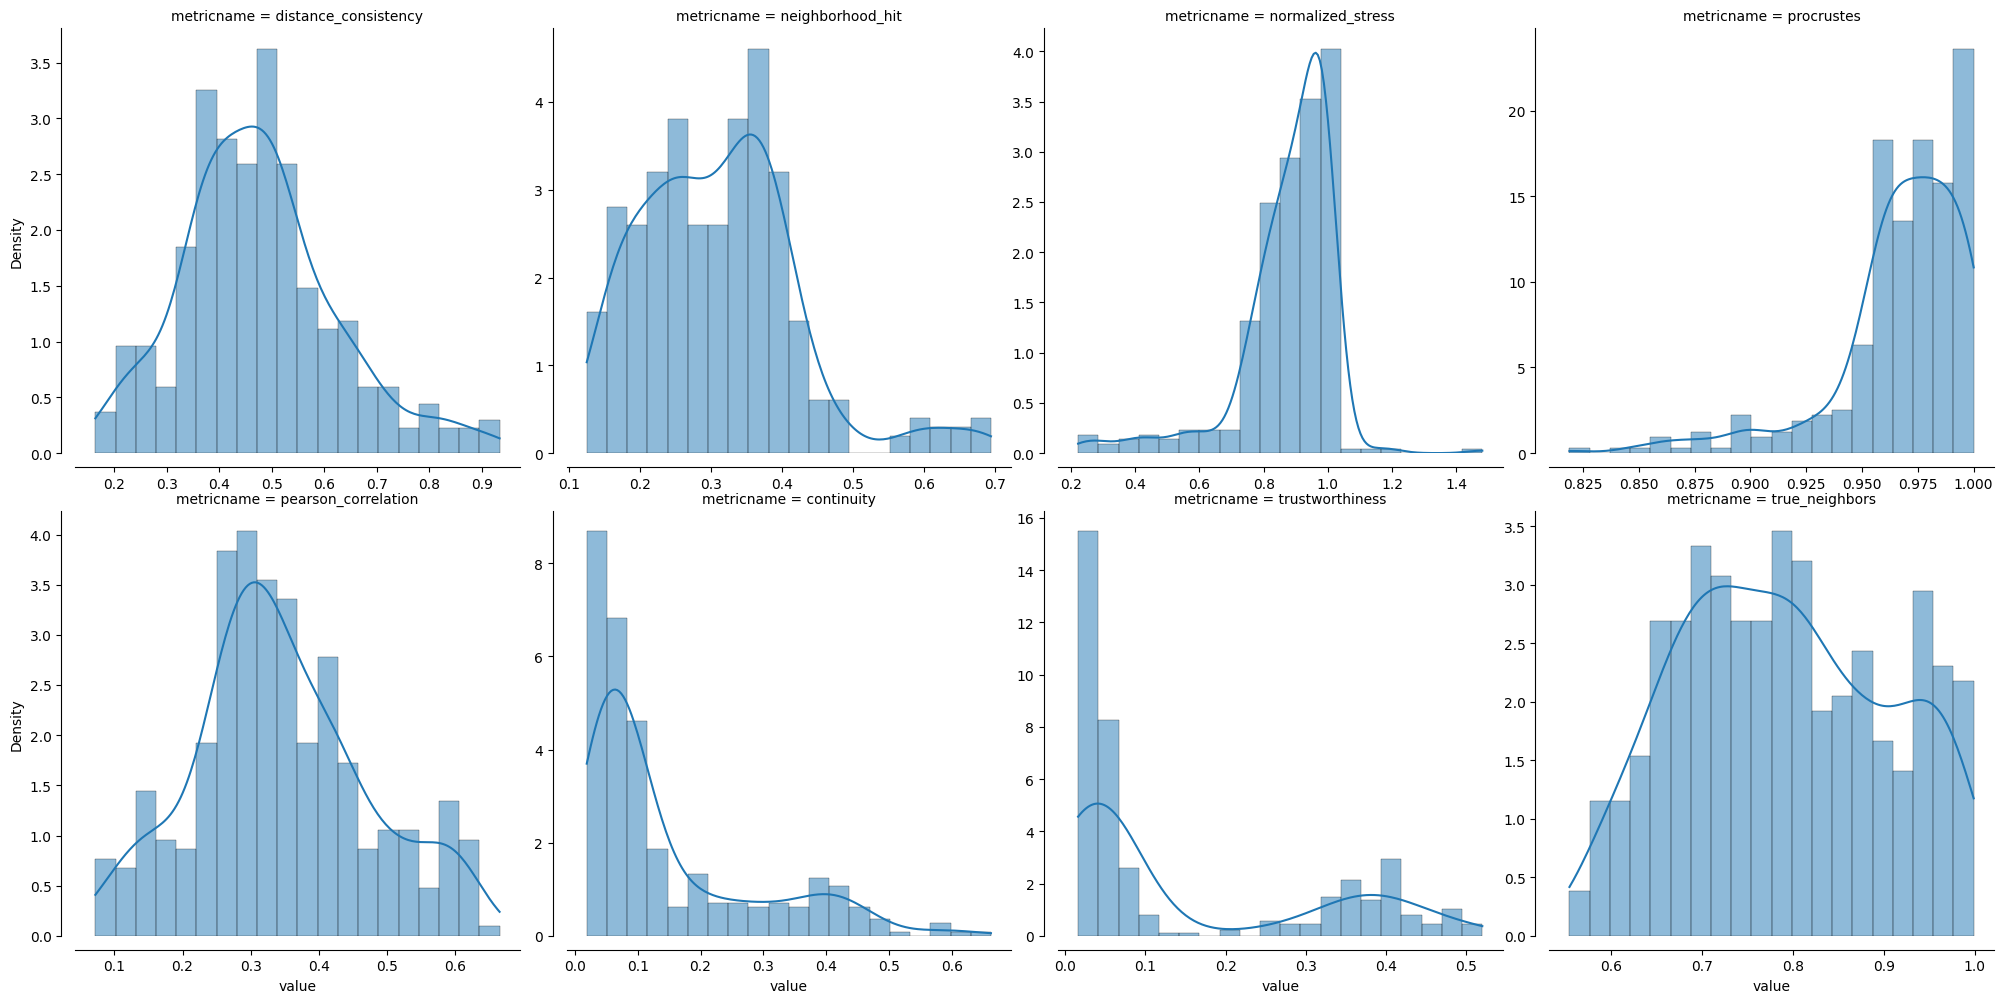

In [ ]:
from scipy import stats

g = sns.displot(
    _data := after_fooling_df.melt(
        id_vars=["dataset", "projection", "k", "metric"],
        value_vars=CLUSTER_REPRESENTATIVES,
        var_name="metricname",
    ),
    kind="hist",
    col="metricname",
    col_wrap=4,
    x="value",
    facet_kws={"sharex": False, "sharey": False},
    common_bins=False,
    common_norm=False,
    bins=20,
    stat="density",
    kde=True,
).despine(left=False, bottom=False, offset=10)



<Axes: ylabel='Count'>

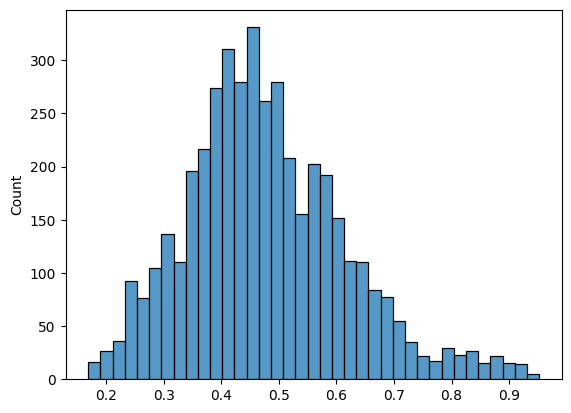

In [26]:
metric_vals = adapted_per_epoch_df[[x for x in CLUSTER_REPRESENTATIVES if x not in ('normalized_stress', 'procrustes', 'true_neighbors')]].dropna().to_numpy()

sorted_metric_vals = np.sort(metric_vals, axis=-1)
# np.diff(sorted_metric_vals, n=1, axis=-1).max(axis=-1)

sns.histplot(x=sorted_metric_vals[:, -1])
